# Train a MNIST TensorFlow Lite for Microcontrollers Model
Inspired by tflite-micro examles

## Setup Environment

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

2023-04-13 17:49:51.729861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 17:49:51.729932: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Configure Defaults

In [2]:
# Define paths to model files
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
MODEL_NO_QUANT_TFLITE_MICRO = MODELS_DIR + 'model_no_quant.cc'

INPUT_IMAGE_WIDTH = 20
INPUT_IMAGE_HEIGHT = 20

NUM_CLASSES = 10
INPUT_SHAPE = (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH, 1)

# Tools

In [3]:
import cv2

# find content in image, cut it out and scale it to input dimensions
def cropscale(img):
    img = np.round(img)
    th = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    bbox = cv2.boundingRect(th[1])
    x, y, w, h = bbox
    if (h < 3):
        x = y = 0
        h = 3
    if (w < 14):
        w = 14
    img = img[y:y+h, x:x+w]
    img = cv2.resize(img, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)
    return img

In [4]:
# apply cropscale to whole dataset
def cropscale_ds(ds):
    ds_new = np.empty((ds.shape[0], INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), dtype="uint8")
    i = 0
    for img in ds:
        ds_new[i] = cropscale(img)
        i += 1
    return ds_new

In [5]:
# tflite to C
def tfliteToC(infile, outfile):
    !xxd -i {infile} > {outfile}
    # Update variable names
    REPLACE_TEXT = infile.replace('/', '_').replace('.', '_')
    !sed -i -e 's/'{REPLACE_TEXT}'/g_model/g' -e 's/^  */\t/g' {outfile}

## Load MNIST

In [6]:
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

7


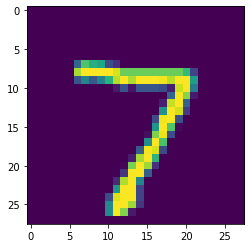

In [7]:
# Example of original data
plt.imshow(x_test[0])
print(y_test[0])

## Pre-Processing

In [8]:
# Find and cut out content. Scale to input size.
x_test = cropscale_ds(x_test)
x_train = cropscale_ds(x_train)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have correct shape
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


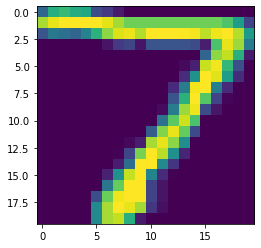

In [9]:
# Example of pre-processed data
plt.imshow(x_test[0])
print(y_test[0])

## Describe Models

In [10]:
# big CNN
model_cnn_big = keras.Sequential(
    [
        keras.Input(shape=(INPUT_SHAPE)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

# big NN
model_nn_big = keras.Sequential([
  layers.Flatten(input_shape=(INPUT_SHAPE)),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_CLASSES, activation="softmax"),
])

# medium NN
model_nn_medium = keras.Sequential([
  layers.Flatten(input_shape=(INPUT_SHAPE)),
  layers.Dense(17, activation='relu'),
  layers.Dense(NUM_CLASSES, activation="softmax"),
])


# small NN
model_nn_small = keras.Sequential([
  layers.Flatten(input_shape=(INPUT_SHAPE)),
  layers.Dense(NUM_CLASSES, activation="softmax"),
])

2023-04-13 17:49:57.794083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-13 17:49:57.794108: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-13 17:49:57.794127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (blackdwarf): /proc/driver/nvidia/version does not exist
2023-04-13 17:49:57.794766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# select small nn
model = model_nn_small
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 400)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                4010      
                                                                 
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [12]:
batch_size = 128
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 1s 1ms/step - loss: 0.7152 - accuracy: 0.8174 - val_loss: 0.3470 - val_accuracy: 0.9178
Epoch 2/10
422/422 [==============================] - 0s 1ms/step - loss: 0.3626 - accuracy: 0.9068 - val_loss: 0.2742 - val_accuracy: 0.9313
Epoch 3/10
422/422 [==============================] - 0s 1ms/step - loss: 0.3145 - accuracy: 0.9167 - val_loss: 0.2504 - val_accuracy: 0.9337
Epoch 4/10
422/422 [==============================] - 0s 1ms/step - loss: 0.2937 - accuracy: 0.9210 - val_loss: 0.2374 - val_accuracy: 0.9368
Epoch 5/10
422/422 [==============================] - 1s 1ms/step - loss: 0.2820 - accuracy: 0.9245 - val_loss: 0.2299 - val_accuracy: 0.9370
Epoch 6/10
422/422 [==============================] - 1s 1ms/step - loss: 0.2742 - accuracy: 0.9258 - val_loss: 0.2243 - val_accuracy: 0.9403
Epoch 7/10
422/422 [==============================] - 0s 1ms/step - loss: 0.2690 - accuracy: 0.9270 - val_loss: 0.2189 - val_accuracy: 0.9413
Epoch 

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2480427771806717
Test accuracy: 0.932699978351593


# Convert Model to TFLite and TFLite Micro

In [14]:
# Save the model to disk
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models/model/assets


In [15]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

2023-04-13 17:50:04.331517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-13 17:50:04.331540: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-13 17:50:04.332129: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: models/model
2023-04-13 17:50:04.332937: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-04-13 17:50:04.332956: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: models/model
2023-04-13 17:50:04.335080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-04-13 17:50:04.335641: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-13 17:50:04.360942: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: models/model
2023-04-13 17:50:04

17596

In [16]:
# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset_orig():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((x_train)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]
# TODO: this is a dummy -> see https://www.tensorflow.org/lite/performance/post_training_quantization
def representative_dataset_random():
    for _ in range(100):
      data = np.random.rand(1, 255, SIMAGE_HEIGHT, SIMAGE_WIDTH)
      yield [data.astype(np.float32)]
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

2023-04-13 17:50:04.525002: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-13 17:50:04.525023: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-13 17:50:04.525148: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: models/model
2023-04-13 17:50:04.525796: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-04-13 17:50:04.525809: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: models/model
2023-04-13 17:50:04.527606: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-13 17:50:04.551836: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: models/model
2023-04-13 17:50:04.559650: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 34502 microseconds.

6152

In [17]:
tfliteToC(MODEL_TFLITE, MODEL_TFLITE_MICRO)
tfliteToC(MODEL_NO_QUANT_TFLITE, MODEL_NO_QUANT_TFLITE_MICRO)

# Evaluation of different Models

In [18]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model,
                                    experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty((len(x_test_),10), dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    #print(interpreter.get_tensor(output_details["index"])[0])
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = np.average(loss_function(y_true, y_pred).numpy())
  y_test_class = np.argmax(y_true, axis = 1)
  y_pred_class = np.argmax(y_pred, axis = 1)
  acc = accuracy_score(y_test_class, y_pred_class, normalize=True)
  return (loss, acc)

In [19]:
loss_tf, acc_tf = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite, acc_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite, acc_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [20]:
# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", acc_tf, loss_tf],
     ["TensorFlow Lite", acc_no_quant_tflite, loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", acc_tflite, loss_tflite]],
     columns = ["Model", "Acc", "Loss/MSE"], index="Model").round(4)
df

,Acc,Loss/MSE
Model,,
TensorFlow,0.9327,0.2480
TensorFlow Lite,0.9327,0.2480
TensorFlow Lite Quantized,0.9331,0.2704


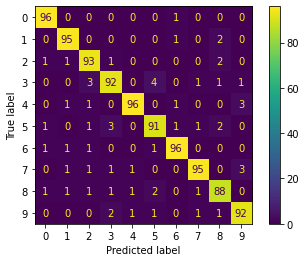

In [21]:
# Confusion matrix
y_pred = predict_tflite(model_tflite, x_test)
y_test_class = np.argmax(y_test, axis = 1)
y_pred_class = np.argmax(y_pred, axis = 1)
cmat = (confusion_matrix(y_test_class, y_pred_class, normalize='pred') * 100).round()
disp = ConfusionMatrixDisplay(confusion_matrix=cmat)
disp.plot()
plt.show()